In [40]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

from gensim.models import word2vec
from keras.preprocessing.sequence import pad_sequences
from sklearn import model_selection

import re
import os
import sys
import pickle
import collections
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
use_cuda = torch.cuda.is_available()
use_cuda

True

## Prepare data

### Load previously processed data

In [3]:
# Reload data that was processed last time
pickle_file = 'data/training_data.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    
    X_small = save['X_small']
    y_small = save['y_small']
    
    del save

In [4]:
print(' '.join(word for word in X_small[0]))

we need a new initiative from the commission on this


In [5]:
print(' '.join(word for word in y_small[0]))

il nous faut une nouvelle initiative de la commission à ce sujet


In [4]:
# For ease of training, only keep sentences shorter than 30 words
X_len = [len(sentence) for sentence in X_small]
y_len = [len(sentence) for sentence in y_small]

min_len = 2
max_len = 30

X_to_keep_ix = np.where((np.array(X_len) >= min_len) & (np.array(X_len) <= max_len))
y_to_keep_ix = np.where((np.array(y_len) >= min_len) & (np.array(y_len) <= max_len))

to_keep_ix = list(set(np.intersect1d(X_to_keep_ix, y_to_keep_ix)))

In [5]:
X_small = X_small[to_keep_ix]
y_small = y_small[to_keep_ix]

In [6]:
# Sanity check
X_len = [len(sentence) for sentence in X_small]
y_len = [len(sentence) for sentence in y_small]

min(X_len), max(X_len), min(y_len), max(y_len)

(2, 30, 2, 30)

### Create word-to-index mapping

In [7]:
def create_word_to_id_mapping(data, max_vocab_size = 20000):
    counter = collections.Counter(np.hstack(data))
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    # Pick the most common ones
    count_pairs = count_pairs[:max_vocab_size]

    # Add 'ZERO', 'GO', and 'UNK'
    # It is important to add 'ZERO' in the beginning
    # to make sure zero padding does not interfere with existing words
    count_pairs.insert(0, ('GO', 0))
    count_pairs.insert(0, ('ZERO', 0))
    count_pairs.append(('UNK', 0))

    # Create mapping for both directions
    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))
    id_to_word = dict(zip(range(len(words)), words))
    
    # Map words to indexes
    data_id = [[word_to_id[word] if word in word_to_id else word_to_id['UNK'] for word in sentence] for sentence in data]
    
    return word_to_id, id_to_word, data_id

In [8]:
X_word_to_id, X_id_to_word, X_id = create_word_to_id_mapping(X_small)
y_word_to_id, y_id_to_word, y_id = create_word_to_id_mapping(y_small)

In [9]:
print(len(X_id), len(y_id), len(X_word_to_id), len(y_word_to_id))

70211 70211 20003 20003


In [10]:
X_vocab_size, y_vocab_size = len(X_word_to_id), len(y_word_to_id)

In [11]:
print(' '.join([X_id_to_word[i] for i in X_id[0]]))

we need a new initiative from the commission on this


In [12]:
print(' '.join([y_id_to_word[i] for i in y_id[0]]))

il nous faut une nouvelle initiative de la commission à ce sujet


### Pad zeros to make sentences equal length

In [16]:
X_id_padded = pad_sequences(X_id, maxlen=max_len, padding='post')
y_id_padded = pad_sequences(y_id, maxlen=max_len, padding='post')

### Leverage pre-trained word vectors

English word vectors downloaded from https://nlp.stanford.edu/projects/glove/

In [32]:
# Code stolen from https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
embeddings_index_en = {}
f = open('data/glove.6B/glove.6B.200d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index_en[word] = coefs
f.close()

French word vectors downloaded from http://fauconnier.github.io/index.html

In [33]:
embeddings_index_fr = word2vec.KeyedVectors.load_word2vec_format(
    'data/frWac_non_lem_no_postag_no_phrase_200_skip_cut100.bin', binary=True)

In [36]:
# Map words to pre-trained embeddings
def map_word_to_pretrained_embedding(embeddings_index, embedding_size, word_to_id):
    vocab_size = len(word_to_id)
    embedding_matrix = np.zeros((vocab_size, embedding_size))
    
    # Keep a running count of matched words
    found = 0
    
    for word, i in word_to_id.items():
        if word in embeddings_index:
            embedding_vector = embeddings_index[word]
            embedding_matrix[i] = embedding_vector
            found += 1
        else:
            # Words not found in embedding index will be randomly initialized
            embedding_matrix[i] = np.random.normal(size=(embedding_size, ))

    return embedding_matrix, found

In [39]:
X_embeddings, X_found = map_word_to_pretrained_embedding(embeddings_index_en, 200, X_word_to_id)
X_embeddings.shape, X_found / X_embeddings.shape[0]

((20003, 200), 0.8669199620056991)

In [40]:
y_embeddings, y_found = map_word_to_pretrained_embedding(embeddings_index_fr, 200, y_word_to_id)
y_embeddings.shape, y_found / y_embeddings.shape[0]

((20003, 200), 0.8486726990951358)

### Save processed data

In [17]:
pickle_file = 'data/training_data.pickle'

f = open(pickle_file, 'wb')
save = {
    'X_small': X_small,
    'y_small': y_small,
    'X_word_to_id': X_word_to_id,
    'X_id_to_word': X_id_to_word,
    'y_word_to_id': y_word_to_id,
    'y_id_to_word': y_id_to_word,
    'X_id_padded': X_id_padded,
    'y_id_padded': y_id_padded,
    'X_embeddings': X_embeddings,
    'y_embeddings': y_embeddings
}

pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [3]:
# Reload data that was processed last time
pickle_file = 'data/training_data.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    
    X_small = save['X_small']
    y_small = save['y_small']
    X_word_to_id = save['X_word_to_id']
    X_id_to_word = save['X_id_to_word']
    y_word_to_id = save['y_word_to_id']
    y_id_to_word = save['y_id_to_word']
    X_id_padded = save['X_id_padded']
    y_id_padded = save['y_id_padded']
    X_embeddings = save['X_embeddings']
    y_embeddings = save['y_embeddings']
    
    del save

### Split data into training and test sets

In [18]:
X_id_padded_train, X_id_padded_test, y_id_padded_train, y_id_padded_test = model_selection.train_test_split(
    X_id_padded, y_id_padded, test_size=0.1, random_state=123456)

In [19]:
[e.shape for e in (X_id_padded_train, X_id_padded_test, y_id_padded_train, y_id_padded_test)]

[(63189, 30), (7022, 30), (63189, 30), (7022, 30)]

In [20]:
print(' '.join([X_id_to_word[i] for i in X_id_padded_train[0]]))

it is as if following the second world war belgium had made UNK degrelle a life senator in order to shield him from legal proceedings by that very act ZERO


In [21]:
print(' '.join([y_id_to_word[i] for i in y_id_padded_train[0]]))

c'est comme si au lendemain de la deuxième guerre mondiale la belgique avait nommé UNK UNK sénateur à vie pour le soustraire par là même aux poursuites judiciaires ZERO ZERO


## Create model

### Encoder

In [22]:
X_embeddings.shape

(20003, 200)

In [23]:
# Convert pre-trained embeddings to a tensor
X_embeddings = torch.FloatTensor(X_embeddings)
y_embeddings = torch.FloatTensor(y_embeddings)

if use_cuda:
    X_embeddings = X_embeddings.cuda()
    y_embeddings = y_embeddings.cuda()

In [24]:
# Create a embedding layer initialized with pre-trained embedding matrix
def create_embedding(init_embeddings, trainable=True):
    vocab_size, embedding_size = init_embeddings.size()
    embedding = nn.Embedding(vocab_size, embedding_size)
    embedding.load_state_dict({'weight': init_embeddings})
    
    if use_cuda:
        embedding = embedding.cuda()
    
    if not trainable:
        for param in embeddings.parameters(): 
            param.requires_grad = False
    
    return embedding, vocab_size, embedding_size

In [25]:
# Check dimensions
create_embedding(X_embeddings)

(Embedding(20003, 200), 20003, 200)

In [26]:
# Create encoder RNN using LSTM
class EncoderRNN(nn.Module):
    def __init__(self, init_embeddings, hidden_size, n_layers=2):
        super(EncoderRNN, self).__init__()
        
        self.embedding, vocab_size, embedding_size = create_embedding(init_embeddings)
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, batch_first=True)
        if use_cuda:
            self.lstm = self.lstm.cuda()
    
    def forward(self, input, states):
        output, states = self.lstm(self.embedding(input), states)
        return output, states
    
    def initHidden(self, batch_size):
        init_hidden_state = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))
        init_cell_state = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))
        
        if use_cuda:
            return (init_hidden_state.cuda(), init_cell_state.cuda())
        else:
            return (init_hidden_state, init_cell_state)

### Decoder

In [27]:
# Randomly initialized weight matrices
def arr(*size):
    return torch.randn(size) / math.sqrt(size[0])

def param(*size):
    if use_cuda:
        return nn.Parameter(arr(*size)).cuda()
    else:
        return nn.Parameter(arr(*size))

In [28]:
# Numpy style dot operation to multiply a 3D matrix with a 2D one
# Based on https://discuss.pytorch.org/t/how-can-i-compute-3d-tensor-2d-tensor-multiplication/639/9
def dot(X, Y):
    return torch.bmm(X, Y.unsqueeze(0).expand(X.size(0), *Y.size()))

$$u^t_i = v^T tanh(W_1′ h_i + W_2′ d_t)$$
$$a^t_i = softmax(u^t_i)$$
$$d_t' = \sum_i^{T_A} a^t_i h_i$$

In [29]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, init_embeddings, hidden_size, n_layers=2):
        super(AttnDecoderRNN, self).__init__()
        
        self.embedding, vocab_size, embedding_size = create_embedding(init_embeddings)
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        # Define weights and intercepts used in paper 1412.7449
        # to construct the allignment matrix: u^t_i = v^T tanh(W_1′ h_i + W_2′ d_t)
        self.W1 = param(hidden_size, hidden_size)
        self.W2 = param(hidden_size, hidden_size)
        self.b = param(hidden_size)
        self.v = param(hidden_size)
        
        # Linear layer to reshape hidden state, concatenated with either the previous true label or prediction,
        # back to the shape of hidden state
        # As the new input to LSTM
        self.new_input = nn.Linear(hidden_size + embedding_size, hidden_size)
        
        # LSTM layers using the new concatenated hidden state as the input
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        
        # Linear layer to reshape data to the shape of output vocabulary
        self.out = nn.Linear(hidden_size, vocab_size)
        
        if use_cuda:
            self.new_input = self.new_input.cuda()
            self.lstm = self.lstm.cuda()
            self.out = self.out.cuda()
    
    def forward(self, input, states, encoder_outputs):
        # u^t_i = v^T tanh(W_1′ h_i + W_2′ d_t)
        W1h = dot(encoder_outputs, self.W1)            # (batch_size, seq_length, hidden_size)
        hidden_state = states[0]                       # (n_layers, batch_size, hidden_size)
        W2d = hidden_state[-1].mm(self.W2)             # (batch_size, hidden_size)
        W1h_W2d = W1h + W2d.unsqueeze(1) + self.b      # (batch_size, seq_length, hidden_size)
        tahn_W1h_W2d = F.tanh(W1h_W2d)                 # (batch_size, seq_length, hidden_size)
        u = (tahn_W1h_W2d * self.v).sum(2)             # (batch_size, seq_length)
        
        # a^t_i = softmax(u^t_i)
        a = F.softmax(u)                               # (batch_size, seq_length)
        
        # d_t' = \sum_i^{T_A} a^t_i h_i
        encoder_outputs_weighted_sum = (a.unsqueeze(2) * encoder_outputs).sum(1)
                                                       # (batch_size, hidden_size)
        
        # Concatenate with decoder input,
        # which is either the previous true label or prediction
        concat_input = torch.cat((encoder_outputs_weighted_sum, self.embedding(input)), 1)
                                                       # (batch_size, hidden_size + embedding_size)
        
        # Reshape the concatenated input back to the shape of hidden state
        reshaped_input = self.new_input(concat_input)  # (batch_size, hidden_size)
        
        # Feed the new input into the LSTM layer
        output, states = self.lstm(reshaped_input.unsqueeze(0), states)
        output = output.squeeze(0)                     # (batch_size, hidden_size)
        
        # Finally, feed to the output layer
        output = self.out(output)                      # (batch_size, vocab_size)
        output = F.log_softmax(output)                 # (batch_size, vocab_size)
        
        return output, states, a

### Training function

In [30]:
def train(X_input, y_input, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion, teacher_forcing_prob=0.5):
    # Initialize variables
    batch_size, X_seq_length = X_input.size()
    y_seq_length = y_input.size()[1]
    
    encoder_states = encoder.initHidden(batch_size)
    decoder_input = Variable(torch.LongTensor([X_word_to_id['GO']] * batch_size))
    if use_cuda:
        decoder_input = decoder_input.cuda()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0

    # Encode
    encoder_outputs, encoder_states = encoder(X_input, encoder_states)
    decoder_states = encoder_states

    # Decode
    if np.random.random() <= teacher_forcing_prob:
        # Teacher forcing: use the true label as the next decoder input
        for i in range(y_seq_length):
            decoder_output, decoder_states, decoder_attention = decoder(decoder_input, decoder_states, encoder_outputs)
            loss += criterion(decoder_output, y_input[:, i])
            decoder_input = y_input[:, i]
    else:
        # Otherwise, use the previous prediction
        for i in range(y_seq_length):
            decoder_output, decoder_states, decoder_attention = decoder(decoder_input, decoder_states, encoder_outputs)
            loss += criterion(decoder_output, y_input[:, i])
            
            # Generate prediction
            top_value, top_index = decoder_output.data.topk(1)
            decoder_input = Variable(top_index.squeeze(1))
            if use_cuda:
                decoder_input = decoder_input.cuda()
    
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / y_seq_length

### Function to train an epoch

In [31]:
def get_batch(X, y, i, batch_size):
    start = i * batch_size
    end = (i + 1) * batch_size
    return X[start:end], y[start:end]

In [32]:
def train_epoch(X, y, batch_size, encoder, decoder, lr=0.01, teacher_forcing_prob=0.5):
    total_loss = 0
    
    encoder_optimizer = optim.RMSprop(encoder.parameters(), lr=lr)
    decoder_optimizer = optim.RMSprop(decoder.parameters(), lr=lr)
    
    criterion = nn.NLLLoss()
    if use_cuda:
        criterion = criterion.cuda()
    
    # loop over batches
    epoch_size = len(X) // batch_size
    
    for i in range(epoch_size):
        X_batch, y_batch = get_batch(X, y, i, batch_size)
        
        X_batch = Variable(torch.from_numpy(X_batch).long())
        y_batch = Variable(torch.from_numpy(y_batch).long())
        
        if use_cuda:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        
        loss = train(X_batch, y_batch, encoder, decoder, encoder_optimizer,
                     decoder_optimizer, criterion, teacher_forcing_prob)
        
        total_loss += loss
        
    return total_loss / epoch_size

### Evaluate

In [33]:
def evaluate(X_input, encoder, decoder, max_len):
    # Initialize variables
    batch_size, X_seq_length = X_input.size()
    
    encoder_states = encoder.initHidden(batch_size)
    decoder_input = Variable(torch.LongTensor([X_word_to_id['GO']] * batch_size))
    if use_cuda:
        decoder_input = decoder_input.cuda()
    
    # Encode
    encoder_outputs, encoder_states = encoder(X_input, encoder_states)
    decoder_states = encoder_states

    # Decode
    decoded_words = np.zeros((batch_size, max_len))
    decoder_attentions = np.zeros((batch_size, max_len, max_len))
    
    for i in range(max_len):
        decoder_output, decoder_states, decoder_attention = decoder(decoder_input, decoder_states, encoder_outputs)
        top_value, top_index = decoder_output.data.topk(1)
        decoded_words[:, i] = top_index.squeeze(1).cpu().numpy()
        decoder_attentions[:, i, :] = decoder_attention.data.cpu().numpy()
        
        # Use the prediction as the next decoder input
        decoder_input = Variable(top_index.squeeze(1))
        if use_cuda:
            decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions

## Run epochs

In [43]:
epochs = 30
max_len = len(X_id_padded[0])
batch_size = 100
hidden_size = 1000
learning_rate = 0.005
teacher_forcing_prob = 0.5

encoder = EncoderRNN(X_embeddings, hidden_size)
decoder = AttnDecoderRNN(y_embeddings, hidden_size)

In [44]:
encoder, decoder

(EncoderRNN (
   (embedding): Embedding(20003, 200)
   (lstm): LSTM(200, 1000, num_layers=2, batch_first=True)
 ), AttnDecoderRNN (
   (embedding): Embedding(20003, 200)
   (new_input): Linear (1200 -> 1000)
   (lstm): LSTM(1000, 1000, num_layers=2)
   (out): Linear (1000 -> 20003)
 ))

In [37]:
# Randomly pick sentences that are shorter than 10 words for testing
X_ix = [i for i, e in enumerate(X_id_padded_test) if np.count_nonzero(e) <= 10 and X_word_to_id['UNK'] not in e]
y_ix = [i for i, e in enumerate(y_id_padded_test) if np.count_nonzero(e) <= 10 and y_word_to_id['UNK'] not in e]
ix = list(set(X_ix).intersection(y_ix))

np.random.seed(123456)
np.random.shuffle(ix)
ix = ix[:3]

X_test = X_id_padded_test[ix]
y_test = y_id_padded_test[ix]

In [ ]:
# Redirect all output to a file
# First, save the default output
orig_stdout = sys.stdout

for i in range(epochs):
    # Redirect output to a file
    log_file_path = 'log_file_epoch_' + str(i) + '.txt'
    f = open(os.path.join('output', log_file_path), 'w')
    sys.stdout = f
    
    print('Epoch:', i)
    
    # Shuffle the training data every epoch to avoid local minima
    np.random.seed(i)
    ix = np.arange(len(X_id_padded_train))
    np.random.shuffle(ix)
    
    X_id_padded_train, y_id_padded_train = X_id_padded_train[ix], y_id_padded_train[ix]
    
    # Print out the first sentence in X and y for sanity check
    print('First sentence in English:', ' '.join([X_id_to_word[ix] for ix in X_id_padded_train[0] if ix > 0]))
    print('First sentence in French:', ' '.join([y_id_to_word[ix] for ix in y_id_padded_train[0] if ix > 0]))    
    
    # Train an epoch    
    train_loss = train_epoch(X_id_padded_train, y_id_padded_train, batch_size,
                             encoder, decoder, learning_rate, teacher_forcing_prob)
    
    print('\nTraining loss:', train_loss)
    
    # Save checkpoint
    torch.save(encoder, 'output/encoder_' + str(i))
    torch.save(decoder, 'output/decoder_' + str(i))
    
    # Evaluate
    # Translate test sentences
    X_test_var = Variable(torch.from_numpy(X_test).long())
    if use_cuda:
        X_test_var = X_test_var.cuda()
    translations, decoder_attentions = evaluate(X_test_var, encoder, decoder, max_len)
    
    for t in range(X_test.shape[0]):
        input_words = ' '.join([X_id_to_word[ix] for ix in X_test[t] if ix > 0])
        target_words = ' '.join([y_id_to_word[ix] for ix in y_test[t] if ix > 0])
        
        # Cut off translations at the first 'ZERO' padding
        first_zero_ix = np.where(translations[t] == 0)[0]
        if len(first_zero_ix) > 0:
            output_words = ' '.join([y_id_to_word[ix] for ix in translations[t][:first_zero_ix[0]]])
        else:
            output_words = ' '.join([y_id_to_word[ix] for ix in translations[t]])
        
        print('\nTranslation of', input_words, ':', output_words)
        print('Actual translation:', target_words)
    
    f.close()

# Restore default output
sys.stdout = orig_stdout

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type AttnDecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


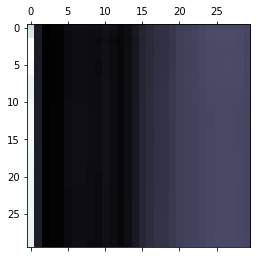

In [51]:
plt.matshow(decoder_attentions[0], cmap='bone')

In [47]:
sys.stdout = orig_stdout
print(1)

1


In [25]:
encoder = torch.load('output/encoder_29')
decoder = torch.load('output/decoder_29')

In [32]:
encoder, decoder

(EncoderRNN (
   (embedding): Embedding(20003, 200)
   (lstm): LSTM(200, 256, num_layers=2, batch_first=True)
 ), AttnDecoderRNN (
   (embedding): Embedding(20003, 200)
   (new_input): Linear (456 -> 256)
   (lstm): LSTM(256, 256, num_layers=2)
   (out): Linear (256 -> 20003)
 ))

In [36]:
X_test_var = Variable(torch.from_numpy(X_test).long())
if use_cuda:
    X_test_var = X_test_var.cuda()
translations = evaluate(X_test_var, encoder, decoder)

for t in range(X_test.shape[0]):
    input_words = ' '.join([X_id_to_word[ix] for ix in X_test[t] if ix > 0])
    target_words = ' '.join([y_id_to_word[ix] for ix in y_test[t] if ix > 0])

    # Cut off translations at the first 'ZERO' padding
    first_zero_ix = np.where(translations[t] == 0)[0]
    if len(first_zero_ix) > 0:
        output_words = ' '.join([y_id_to_word[ix] for ix in translations[t][:first_zero_ix[0]]])
    else:
        output_words = ' '.join([y_id_to_word[ix] for ix in translations[t]])

    print('\nTranslation of', input_words, ':', output_words)
    print('Actual translation:', target_words)


Translation of on this the commission is determined and optimistic : en effet de de
Actual translation: à cet égard la commission est déterminée et optimiste

Translation of we must take this phenomenon into account : nous est de de
Actual translation: nous devons prendre en compte ce phénomène

Translation of my final task as rapporteur is a thankful one : il est de de
Actual translation: ma dernière tâche de rapporteur est d’exprimer mes remerciements
